## Capstone Part 2 - Campgrounds in the US. From https://ridb.recreation.gov/


In my capstone project, I plan to do an analysis of the data and then model the data to predict reservations for various campsites.
I plan to use EDA and various regression models
One risk would be weather. If a year has very different weather than the prior year, this can result in the prediction being off.
My initial goals, is to clean the data and run the complete analysis prior to modeling.
I plan to do a train, test, split to test the data.
In addition, I am taking a sample of the data at 1/100th of the initial amount for the dataset (2015).

There are 3 dates in my dataset and I converted them to datetime format. OrderDate has no null values while StartDate and EndDate have a significant number of null values. I'm thinking I may base my predictions primarily on the OrderDate, but will see once I do EDA with the dates. Also, I plan to use the string time (strftime) for the dates.

Data Aquisition: I got the data from the recreation.gov website. In addition to downloading the data, I reviewed the data dictionary and looked at the Entity Relationship diagram. In my investigation, it turned out that there is a Camping dataset that maps to the Reservations dataset. I mapped the data from thie dataset and excluded the others as described later in this notebook.

In [112]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, r2_score
from sklearn.cluster import DBSCAN

import scipy.stats as stats
from sklearn.tree import DecisionTreeRegressor

from ipywidgets import *
from IPython.display import display


plt.rc("figure", figsize=(9, 7))
sns.set_style('whitegrid')

from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

In [113]:
df15 = pd.read_csv('/Users/stevenmandel/Downloads/2015.csv',encoding='ISO-8859-1',error_bad_lines=False)

In [114]:
df15.columns

Index(['HistoricalReservationID', 'OrderNumber', 'Agency', 'OrgID',
       'CodeHierarchy', 'RegionCode', 'RegionDescription', 'ParentLocationID',
       'ParentLocation', 'LegacyFacilityID', 'Park', 'SiteType', 'UseType',
       'ProductID', 'EntityType', 'EntityID', 'FacilityID', 'FacilityZIP',
       'FacilityState', 'FacilityLongitude', 'FacilityLatitude', 'CustomerZIP',
       'CustomerState', 'CustomerCountry', 'Tax', 'UseFee', 'TranFee',
       'AttrFee', 'TotalBeforeTax', 'TotalPaid', 'StartDate', 'EndDate',
       'OrderDate', 'NumberOfPeople', 'Tent', 'Popup', 'Trailer',
       'RVMotorhome', 'Boat', 'HorseTrailer', 'Car', 'FifthWheel', 'Van',
       'CanoeKayak', 'BoatTrailer', 'Motorcycle', 'Truck', 'Bus', 'Bicycle',
       'Snowmobile', 'OffRoadlAllTerrainVehicle', 'PowerBoat', 'PickupCamper',
       'LargeTentOver9x12', 'SmallTent', 'Marinaboat'],
      dtype='object')

In [117]:
df15['FacilityID'].head()

0    234164.0
1    233619.0
2    234735.0
3    232748.0
4    234735.0
Name: FacilityID, dtype: float64

In [118]:
df15['EntityType'] # Looking at the data dictionary, it turns out that the only camping related entity type is "Site"

0              Site
1              Site
2          Entrance
3               POS
4          Entrance
5               POS
6           LOTTERY
7              Site
8              Site
9              Site
10              POS
11             Site
12             Site
13             Site
14             Site
15             Site
16             Site
17         Entrance
18         Entrance
19             Site
20             Site
21             Site
22             Site
23             Site
24             Site
25             Site
26             Site
27             Site
28             Site
29             Site
             ...   
2949189    Entrance
2949190         POS
2949191        Site
2949192        Tour
2949193        Site
2949194        Site
2949195        Tour
2949196     LOTTERY
2949197    Entrance
2949198         POS
2949199        Tour
2949200         POS
2949201         POS
2949202        Site
2949203        Site
2949204        Site
2949205        Site
2949206        Site
2949207        Site


# Download Camping specific dataset

The camping specific dataset contains FacilityID which are specific to parks that have camping specific facilities. In order to only have camping-related reservationships, it was necessary to identify the unique FacilityIDs and then run a lambda function to map the Facility ID of the reservation dataset only to those in the Campsite dataset that match up with the unique FacilityID and assign it back to a new dataframe (df15Camp1a). It was necessary to rename the FacilityID to match the same case as in the Campground dataset.

In [119]:
df15.columns

Index(['HistoricalReservationID', 'OrderNumber', 'Agency', 'OrgID',
       'CodeHierarchy', 'RegionCode', 'RegionDescription', 'ParentLocationID',
       'ParentLocation', 'LegacyFacilityID', 'Park', 'SiteType', 'UseType',
       'ProductID', 'EntityType', 'EntityID', 'FacilityID', 'FacilityZIP',
       'FacilityState', 'FacilityLongitude', 'FacilityLatitude', 'CustomerZIP',
       'CustomerState', 'CustomerCountry', 'Tax', 'UseFee', 'TranFee',
       'AttrFee', 'TotalBeforeTax', 'TotalPaid', 'StartDate', 'EndDate',
       'OrderDate', 'NumberOfPeople', 'Tent', 'Popup', 'Trailer',
       'RVMotorhome', 'Boat', 'HorseTrailer', 'Car', 'FifthWheel', 'Van',
       'CanoeKayak', 'BoatTrailer', 'Motorcycle', 'Truck', 'Bus', 'Bicycle',
       'Snowmobile', 'OffRoadlAllTerrainVehicle', 'PowerBoat', 'PickupCamper',
       'LargeTentOver9x12', 'SmallTent', 'Marinaboat'],
      dtype='object')

In [120]:
dftemp = pd.read_csv('/Users/stevenmandel/Downloads/RIDBFullExport_v1/Campsites_API_v1.csv',encoding='ISO-8859-1',error_bad_lines=False)

In [121]:
dftemp = dftemp.rename(columns={'FACILITYID':'FacilityID'})

In [122]:
dftemp.FacilityID.dtypes

dtype('int64')

In [123]:
dftemp.shape

(99018, 9)

In [124]:
df15.FacilityID.dtypes

dtype('float64')

In [125]:
df15['FacilityID'].shape # before mapping, df15['FacilityID'].shape is 2949219,

(2949219,)

In [126]:
dftemp['FacilityID'].shape # before mapping, dftemp['FacilityID'].shape is 99018,

(99018,)

In [127]:
df15['FacilityID'].head()

0    234164.0
1    233619.0
2    234735.0
3    232748.0
4    234735.0
Name: FacilityID, dtype: float64

In [129]:
len(df15['FacilityID'].unique()) # len(df15['FacilityID'].unique()) b4 mapping is 3089

3089

In [130]:
uniq = dftemp['FacilityID'].unique()

In [131]:
uniq

array([232446, 232448, 232447, ..., 272094, 272098, 272097])

In [132]:
df15Camp1a = df15[df15['FacilityID'].map(lambda x: True if x in uniq else False)] # like .apply 

# Data Cleaning 

In [133]:
df15Camp1a.shape

(2186714, 56)

In [134]:
df15Camp1a.columns

Index(['HistoricalReservationID', 'OrderNumber', 'Agency', 'OrgID',
       'CodeHierarchy', 'RegionCode', 'RegionDescription', 'ParentLocationID',
       'ParentLocation', 'LegacyFacilityID', 'Park', 'SiteType', 'UseType',
       'ProductID', 'EntityType', 'EntityID', 'FacilityID', 'FacilityZIP',
       'FacilityState', 'FacilityLongitude', 'FacilityLatitude', 'CustomerZIP',
       'CustomerState', 'CustomerCountry', 'Tax', 'UseFee', 'TranFee',
       'AttrFee', 'TotalBeforeTax', 'TotalPaid', 'StartDate', 'EndDate',
       'OrderDate', 'NumberOfPeople', 'Tent', 'Popup', 'Trailer',
       'RVMotorhome', 'Boat', 'HorseTrailer', 'Car', 'FifthWheel', 'Van',
       'CanoeKayak', 'BoatTrailer', 'Motorcycle', 'Truck', 'Bus', 'Bicycle',
       'Snowmobile', 'OffRoadlAllTerrainVehicle', 'PowerBoat', 'PickupCamper',
       'LargeTentOver9x12', 'SmallTent', 'Marinaboat'],
      dtype='object')

In [135]:
df15Camp1a[df15Camp1a['FacilityID'].isin([232448])].sort_values(['HistoricalReservationID'])

,HistoricalReservationID,OrderNumber,Agency,OrgID,CodeHierarchy,RegionCode,RegionDescription,ParentLocationID,ParentLocation,LegacyFacilityID,...,Truck,Bus,Bicycle,Snowmobile,OffRoadlAllTerrainVehicle,PowerBoat,PickupCamper,LargeTentOver9x12,SmallTent,Marinaboat
583672,1832830060,2-30960305,NPS,128,|1|70904|74327|74296|70926|,YOSE-8800,Yosemite National Park,74327,Pacific West Region,70926,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
583699,1832876908,2-30960014,NPS,128,|1|70904|74327|74296|70926|,YOSE-8800,Yosemite National Park,74327,Pacific West Region,70926,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
583743,1832921983,2-30961839,NPS,128,|1|70904|74327|74296|70926|,YOSE-8800,Yosemite National Park,74327,Pacific West Region,70926,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
712969,1832953200,2-30962917,NPS,128,|1|70904|74327|74296|70926|,YOSE-8800,Yosemite National Park,74327,Pacific West Region,70926,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
583780,1832975491,2-30962331,NPS,128,|1|70904|74327|74296|70926|,YOSE-8800,Yosemite National Park,74327,Pacific West Region,70926,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
583803,1832990227,2-30963084,NPS,128,|1|70904|74327|74296|70926|,YOSE-8800,Yosemite National Park,74327,Pacific West Region,70926,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
583804,1832990249,2-30963085,NPS,128,|1|70904|74327|74296|70926|,YOSE-8800,Yosemite National Park,74327,Pacific West Region,70926,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
583830,1833012951,2-30964239,NPS,128,|1|70904|74327|74296|70926|,YOSE-8800,Yosemite National Park,74327,Pacific West Region,70926,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
583844,1833028859,2-30964272,NPS,128,|1|70904|74327|74296|70926|,YOSE-8800,Yosemite National Park,74327,Pacific West Region,70926,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
583952,1833064545,2-30964924,NPS,128,|1|70904|74327|74296|70926|,YOSE-8800,Yosemite National Park,74327,Pacific West Region,70926,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [136]:
df15Camp1a.EntityType.value_counts()

Site    1965887
POS      220827
Name: EntityType, dtype: int64

In [137]:
df15Camp1a.columns

Index(['HistoricalReservationID', 'OrderNumber', 'Agency', 'OrgID',
       'CodeHierarchy', 'RegionCode', 'RegionDescription', 'ParentLocationID',
       'ParentLocation', 'LegacyFacilityID', 'Park', 'SiteType', 'UseType',
       'ProductID', 'EntityType', 'EntityID', 'FacilityID', 'FacilityZIP',
       'FacilityState', 'FacilityLongitude', 'FacilityLatitude', 'CustomerZIP',
       'CustomerState', 'CustomerCountry', 'Tax', 'UseFee', 'TranFee',
       'AttrFee', 'TotalBeforeTax', 'TotalPaid', 'StartDate', 'EndDate',
       'OrderDate', 'NumberOfPeople', 'Tent', 'Popup', 'Trailer',
       'RVMotorhome', 'Boat', 'HorseTrailer', 'Car', 'FifthWheel', 'Van',
       'CanoeKayak', 'BoatTrailer', 'Motorcycle', 'Truck', 'Bus', 'Bicycle',
       'Snowmobile', 'OffRoadlAllTerrainVehicle', 'PowerBoat', 'PickupCamper',
       'LargeTentOver9x12', 'SmallTent', 'Marinaboat'],
      dtype='object')

In [138]:
df15Camp1a 

,HistoricalReservationID,OrderNumber,Agency,OrgID,CodeHierarchy,RegionCode,RegionDescription,ParentLocationID,ParentLocation,LegacyFacilityID,...,Truck,Bus,Bicycle,Snowmobile,OffRoadlAllTerrainVehicle,PowerBoat,PickupCamper,LargeTentOver9x12,SmallTent,Marinaboat
0,2019039433,2-32196786,USFS,131,|1|70903|74312|74395|74751|74197|,F40204,CASCADE RD,74395,BOISE NF - FS,74197,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019134646,2-32195127,USACE,130,|1|70902|74307|74362|74636|73388|,CM5002570,CANTON LAKE,74362,TULSA DISTRICT,73388,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2068426196,3-3347118,USACE,130,|1|70902|74307|74360|74612|71505|,CM2075357,GRANGER LAKE,74360,FORT WORTH DIST.,71505,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2071372901,3-3352526,USACE,130,|1|70902|74307|74360|74595|71264|,CM2001330,BELTON LAKE,74360,FORT WORTH DIST.,71264,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2071844350,2-32696137,USACE,130,|1|70902|74304|74350|74558|71412|,CH3008370,J PERCY PRIEST DAM,74350,NASHVILLE DISTRICT,71412,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2071844376,2-32696138,NPS,128,|1|70904|74325|74283|70967|,GRSM-5460,Great Smoky Mountains National Park,74325,Southeast Region,70967,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2071844441,2-32696139,USACE,130,|1|70902|74301|74336|74479|73131|,CB3016691,LAKE SHELBYVILLE,74336,ST. LOUIS DISTRICT,73131,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,2071844608,3-3353441,NPS,128,|1|70904|74327|74296|70929|,YOSE-8800,Yosemite National Park,74327,Pacific West Region,70929,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,2071844658,2-32696140,USACE,130,|1|70902|74305|74354|74574|71461|,CK5013230,OKATIBBEE LAKE,74354,MOBILE DISTRICT,71461,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,2071844690,2-32696141,USFS,131,|1|70903|74315|74456|74944|70322|,F92105,POTOMAC RD - FS,74456,MONONGAHELA NF -FS,70322,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Drop the following columns that either have no data or are not relevant.

In [141]:
#df15Camp1a = df15Camp1a.drop(labels=['HistoricalReservationID','LegacyFacilityID','ParentLocationID','OrgID','FacilityID','EntityID','FacilityZIP'], axis=1).copy()

In [142]:
df15Camp1a = df15Camp1a.drop(labels=['ProductID','PowerBoat','OffRoadlAllTerrainVehicle','Snowmobile','Bicycle','Motorcycle','Truck','BoatTrailer','CanoeKayak','Car','HorseTrailer','Bus','Marinaboat'], axis=1).copy()

In [143]:
df15Camp1a.shape

(2186714, 36)

# Drop NA Values

These items below are specific to the type of camping being done. In some cases there may be a small tent and a large tent, for instance, but for the most part they are unique means of camping. There were some cases in which nothing was specified as it is an optional field but most of them contained a value. As such, I did a dropna and set 'how' to 'all'. This way only those that contained no value at all would be dropped. Later, the remaining null values will be imputed to 0 as they already contain a specified value.

In [144]:
df15Camp1a.dropna(subset=['Tent','Popup','Trailer', 'RVMotorhome', 'Boat', 'FifthWheel', 'Van','PickupCamper','LargeTentOver9x12','SmallTent'],how='all', inplace=True)

In [145]:
df15Camp1a.columns

Index(['OrderNumber', 'Agency', 'CodeHierarchy', 'RegionCode',
       'RegionDescription', 'ParentLocation', 'Park', 'SiteType', 'UseType',
       'EntityType', 'FacilityState', 'FacilityLongitude', 'FacilityLatitude',
       'CustomerZIP', 'CustomerState', 'CustomerCountry', 'Tax', 'UseFee',
       'TranFee', 'AttrFee', 'TotalBeforeTax', 'TotalPaid', 'StartDate',
       'EndDate', 'OrderDate', 'NumberOfPeople', 'Tent', 'Popup', 'Trailer',
       'RVMotorhome', 'Boat', 'FifthWheel', 'Van', 'PickupCamper',
       'LargeTentOver9x12', 'SmallTent'],
      dtype='object')

In [146]:
df15Camp1a.CustomerZIP.dropna(how='any',inplace=True)

In [147]:
df15Camp1a.CustomerState.dropna(how='any',inplace=True)

In [148]:
df15Camp1a.dropna(subset=['FacilityLongitude','FacilityLatitude', 'CustomerZIP','CustomerState','CustomerCountry'],how='any',inplace=True)

In [149]:
df15Camp1a.isnull().sum()

OrderNumber                0
Agency                     0
CodeHierarchy              0
RegionCode                 0
RegionDescription          0
ParentLocation             0
Park                       0
SiteType                   0
UseType                    0
EntityType                 0
FacilityState              0
FacilityLongitude          0
FacilityLatitude           0
CustomerZIP                0
CustomerState              0
CustomerCountry            0
Tax                        0
UseFee                     0
TranFee                    0
AttrFee                    0
TotalBeforeTax             0
TotalPaid                  0
StartDate                  0
EndDate                    0
OrderDate                  0
NumberOfPeople             0
Tent                  799067
Popup                1367072
Trailer              1125839
RVMotorhome          1234251
Boat                 1436369
FifthWheel           1301420
Van                  1401830
PickupCamper         1410097
LargeTentOver9

# Set Dates to Date Time format

Convert dates to be in datetime format so that they can be used in calculations. Ultimately we will be looking at the median Order Month and median Start Month for each park and using thees as features in the model.

In [150]:
df15Camp1a['OrderDate'] = pd.to_datetime(df15Camp1a['OrderDate'])

df15Camp1a['OrderYear'] = df15Camp1a['OrderDate'].dt.year

df15Camp1a['OrderMonth'] = df15Camp1a['OrderDate'].dt.month

df15Camp1a['OrderDay']  = df15Camp1a['OrderDate'].dt.day


In [151]:
df15Camp1a['StartDate'] = pd.to_datetime(df15Camp1a['StartDate'])

df15Camp1a['StartMonth'] = df15Camp1a['StartDate'].dt.month

df15Camp1a['StartDay'] = df15Camp1a['StartDate'].dt.day

df15Camp1a['StartYear'] = df15Camp1a['StartDate'].dt.year
df15Camp1a['StartDate'].head()

0    2015-08-21
7    2015-09-23
8    2015-10-10
12   2015-09-25
13   2015-09-25
Name: StartDate, dtype: datetime64[ns]

In [152]:
df15Camp1a['EndDate'] = pd.to_datetime(df15Camp1a['EndDate'])

df15Camp1a['EndMonth'] = df15Camp1a['EndDate'].dt.month

df15Camp1a['EndDay'] = df15Camp1a['EndDate'].dt.day

df15Camp1a['EndYear'] = df15Camp1a['EndDate'].dt.year



df15Camp1a['EndDate'].head()

0    2015-08-23
7    2015-09-25
8    2015-10-12
12   2015-09-27
13   2015-09-26
Name: EndDate, dtype: datetime64[ns]

Create a csv file of the cleaned data.

In [153]:

df15Camp1a.to_csv('df15Camp1a.csv', index=False)

# Get the median dates for Order Month and Start Month

While I chose the 2015 Reservation dataset, there were cases that crossed over the year. To handle this, I set the OrderYear and StartYear to be 2015. Then I calculated the median order month and median start month for the parks and renamed the columns to reflect this.

In [47]:
Twenty_Fifteen_dates = df15Camp1a.loc[(df15Camp1a['OrderYear'] == 2015) & (df15Camp1a['StartYear'] == 2015), :] # use

Order_Start_Month2015 = Twenty_Fifteen_dates.groupby('Park')[['OrderMonth', 'StartMonth']].median() # use

Order_Start_Month2015.rename(columns={'OrderMonth':'MedianOrderMo', 'StartMonth':'MedianStartMo'}, inplace=True) # use

Order_Start_Month2015.head()

,MedianOrderMo,MedianStartMo
Park,,
ACKERMAN CAMPGROUND,6.0,7.0
ACORN CAMPGROUND,2.0,2.0
ACORN VALLEY,6.0,7.0
ADELAIDE CAMPGROUND,5.0,7.0
AIRPORT PARK,3.0,5.0


# Use Groupby to group by Individual Parks

Due to the fact that the data we are working with is transactional -- reservations that were booked to campsites, it is necessary to group the data. For example, a single reservation at a park will contain all of the pertinent data such as the order date, the total, whether it will be for tent camping or an RV, etc. By grouping all of the reservations per park, we are able to obtain the sums of all the relevant data.

In [154]:
df15Camp1a = df15Camp1a.groupby('Park')[['SiteType', 'UseType',
       'EntityType', 'FacilityState', 
       'CustomerZIP', 'CustomerState', 'CustomerCountry', 'Tax', 'UseFee',
       'TranFee', 'AttrFee', 'TotalBeforeTax', 'TotalPaid', 'StartDate',
       'EndDate', 'OrderDate', 'NumberOfPeople', 'Tent', 'Popup', 'Trailer',
       'RVMotorhome', 'Boat', 'FifthWheel', 'Van', 'PickupCamper',
       'LargeTentOver9x12', 'SmallTent']].sum()   

In [155]:
df15Camp1a = df15Camp1a.reset_index().copy() 

In [156]:
df15Camp1a

,Park,Tax,UseFee,TranFee,AttrFee,TotalBeforeTax,TotalPaid,NumberOfPeople,Tent,Popup,Trailer,RVMotorhome,Boat,FifthWheel,Van,PickupCamper,LargeTentOver9x12,SmallTent
0,ACKERMAN CAMPGROUND,0.00,2398.50,1513.00,0.0,3920.50,3920.50,520,88.0,5.0,23.0,7.0,NaN,4.0,3.0,5.0,NaN,NaN
1,ACORN CAMPGROUND,0.00,17596.00,950.00,0.0,18584.00,18584.00,2913,441.0,18.0,121.0,117.0,NaN,69.0,89.0,32.0,NaN,NaN
2,ACORN VALLEY,0.00,5719.00,662.00,0.0,6691.00,6691.00,1221,281.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0
3,ADELAIDE CAMPGROUND,0.00,1500.00,176.00,0.0,1726.00,1726.00,466,19.0,1.0,3.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN
4,AIRPORT PARK,0.00,55616.00,2660.00,0.0,59118.00,59118.00,9603,162.0,39.0,882.0,631.0,NaN,471.0,16.0,16.0,NaN,NaN
5,AKERS,0.00,4558.00,60.00,0.0,4618.00,4618.00,1054,65.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
6,AL TAYLOR CABIN,0.00,175.00,18.00,0.0,193.00,193.00,8,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,ALBENI COVE,0.00,5480.00,360.00,0.0,5950.00,5950.00,593,79.0,12.0,30.0,6.0,NaN,NaN,1.0,10.0,NaN,NaN
8,ALBERT MOSER,0.00,2649.00,898.00,0.0,3559.00,3559.00,525,51.0,6.0,18.0,3.0,NaN,5.0,1.0,1.0,NaN,NaN
9,ALBION BASIN,0.00,8189.00,3254.00,0.0,11483.00,11483.00,1690,248.0,22.0,16.0,6.0,NaN,1.0,12.0,8.0,NaN,NaN


In [157]:
df15Camp1a.columns

Index(['Park', 'Tax', 'UseFee', 'TranFee', 'AttrFee', 'TotalBeforeTax',
       'TotalPaid', 'NumberOfPeople', 'Tent', 'Popup', 'Trailer',
       'RVMotorhome', 'Boat', 'FifthWheel', 'Van', 'PickupCamper',
       'LargeTentOver9x12', 'SmallTent'],
      dtype='object')

# Create ParkState to keep track of Parks within States

FacilityState was removed after the groupby. By creating a dictionary from the original Reservations dataset and mapping FacilityState to Park.

In [158]:
ParkState = df15[['Park','FacilityState']] 

my_dict = ParkState.set_index('Park').to_dict()
contents = my_dict['FacilityState'] #.keys()

In [159]:
df15Camp1a['FacilityState'] = df15Camp1a['Park'].map(contents)

In [160]:
df15Camp1a['FacilityState'].head()

0    CA
1    CA
2    IA
3    UT
4    TX
Name: FacilityState, dtype: object

# Create Regions and Map States to Regions

In looking at the data, there were some distinct differences across regions as far as things such as the type of the equipment used for camping, as well as the average start months. As a result, I created 10 regions and mapped each state to a region. The regions will be the target in my models.

In [161]:
def toRegion(FacilityState):
    if FacilityState in ['WA', 'OR', 'CA']:
        return 'Pacific Coast'
    elif FacilityState in ['VA', 'WV','NC', 'TN', 'KY']:
        return 'Appalachian'
    elif FacilityState in ['NY', 'NJ', 'PA', 'DE','MD']:
        return 'Mid Atlantic'
    elif FacilityState in ['ME', 'VT', 'NH', 'MA', 'CT', 'RI' ]:
        return 'New England'
    elif FacilityState in ['AR','LA', 'MS', 'AL', 'GA', 'FL', 'SC']:
        return 'Southeast'
    elif FacilityState in ['OH', 'MI', 'WI', 'IL', 'IN']:
        return 'Midwest' 
    elif FacilityState in ['MN', 'ND', 'SD', 'IA', 'NE', 'MO', 'KS']:
        return 'Heartland' 
    elif FacilityState in ['AZ', 'NM', 'TX', 'OK']:
        return 'Southwest'
    elif FacilityState in ['ID', 'MT', 'CO', 'WY', 'UT', 'NV']:
        return 'Mountain'
    elif FacilityState in ['AK', 'HI']:
        return 'Noncontiguous'

In [162]:
df15Camp1a['Region'] = df15Camp1a['FacilityState'].map(toRegion)

In [163]:
df15Camp1a.columns

Index(['Park', 'Tax', 'UseFee', 'TranFee', 'AttrFee', 'TotalBeforeTax',
       'TotalPaid', 'NumberOfPeople', 'Tent', 'Popup', 'Trailer',
       'RVMotorhome', 'Boat', 'FifthWheel', 'Van', 'PickupCamper',
       'LargeTentOver9x12', 'SmallTent', 'FacilityState', 'Region'],
      dtype='object')

# Merge the Median Order and Median Start Month (from above) to the dataframe

In [165]:
df15CampFinal= pd.merge(Order_Start_Month2015.reset_index(), df15Camp1a, on='Park')

# Impute null values to be 0

Most of the null values resulted from categorical items such as Tent, RV, Van, Fifth Wheel, etc. Most reservations consisted of one or two of these. Note that these attributes are optional. I chose to impute the remaining null values to zero. 

In [166]:
df15CampFinal.isnull().sum()

Park                    0
MedianOrderMo           0
MedianStartMo           0
Tax                     0
UseFee                  0
TranFee                 0
AttrFee                 0
TotalBeforeTax          0
TotalPaid               0
NumberOfPeople          0
Tent                   45
Popup                 490
Trailer               326
RVMotorhome           342
Boat                 2081
FifthWheel            524
Van                   620
PickupCamper          574
LargeTentOver9x12    1913
SmallTent            1937
FacilityState           0
Region                  0
dtype: int64

In [167]:
df15CampFinal[['Tent','Trailer','RVMotorhome','FifthWheel','Popup','Van','PickupCamper','LargeTentOver9x12', 'SmallTent']] = df15CampFinal[['Tent','Trailer','RVMotorhome','FifthWheel','Popup','Van','PickupCamper','LargeTentOver9x12', 'SmallTent']].fillna(value=0)

In [170]:
df15CampFinal.drop('Boat', axis=1, inplace=True) # Dropped Boat as it had no items.

In [171]:
df15CampFinal.isnull().sum()

Park                 0
MedianOrderMo        0
MedianStartMo        0
Tax                  0
UseFee               0
TranFee              0
AttrFee              0
TotalBeforeTax       0
TotalPaid            0
NumberOfPeople       0
Tent                 0
Popup                0
Trailer              0
RVMotorhome          0
FifthWheel           0
Van                  0
PickupCamper         0
LargeTentOver9x12    0
SmallTent            0
FacilityState        0
Region               0
dtype: int64

# EDA

In [172]:
df15CampFinal.shape

(2104, 21)

In [ ]:
numeric = df15Camp1a._get_numeric_data()

In [173]:
corrmat = df15CampFinal.corr()

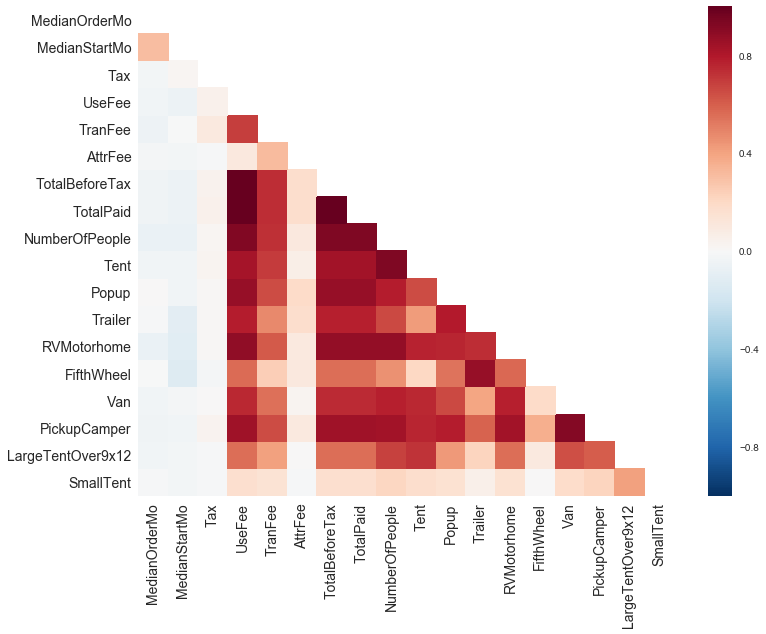

In [174]:
fig, ax = plt.subplots(figsize = (12, 9))
                       
# Generate a mask for the upper triangle (taken from seaborn example gallery)                       
mask = np.zeros_like(corrmat, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Plot the heatmap with seaborn.
# Assign the matplotlib axis the function returns. This will let us resize the labels.
ax = sns.heatmap(corrmat, mask=mask, ax=ax)

# Resize the labels.
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14)

# If you put plt.show() at the bottom, it prevents those useless printouts from matplotlib.
plt.show()

In [177]:
numeric = df15CampFinal._get_numeric_data()

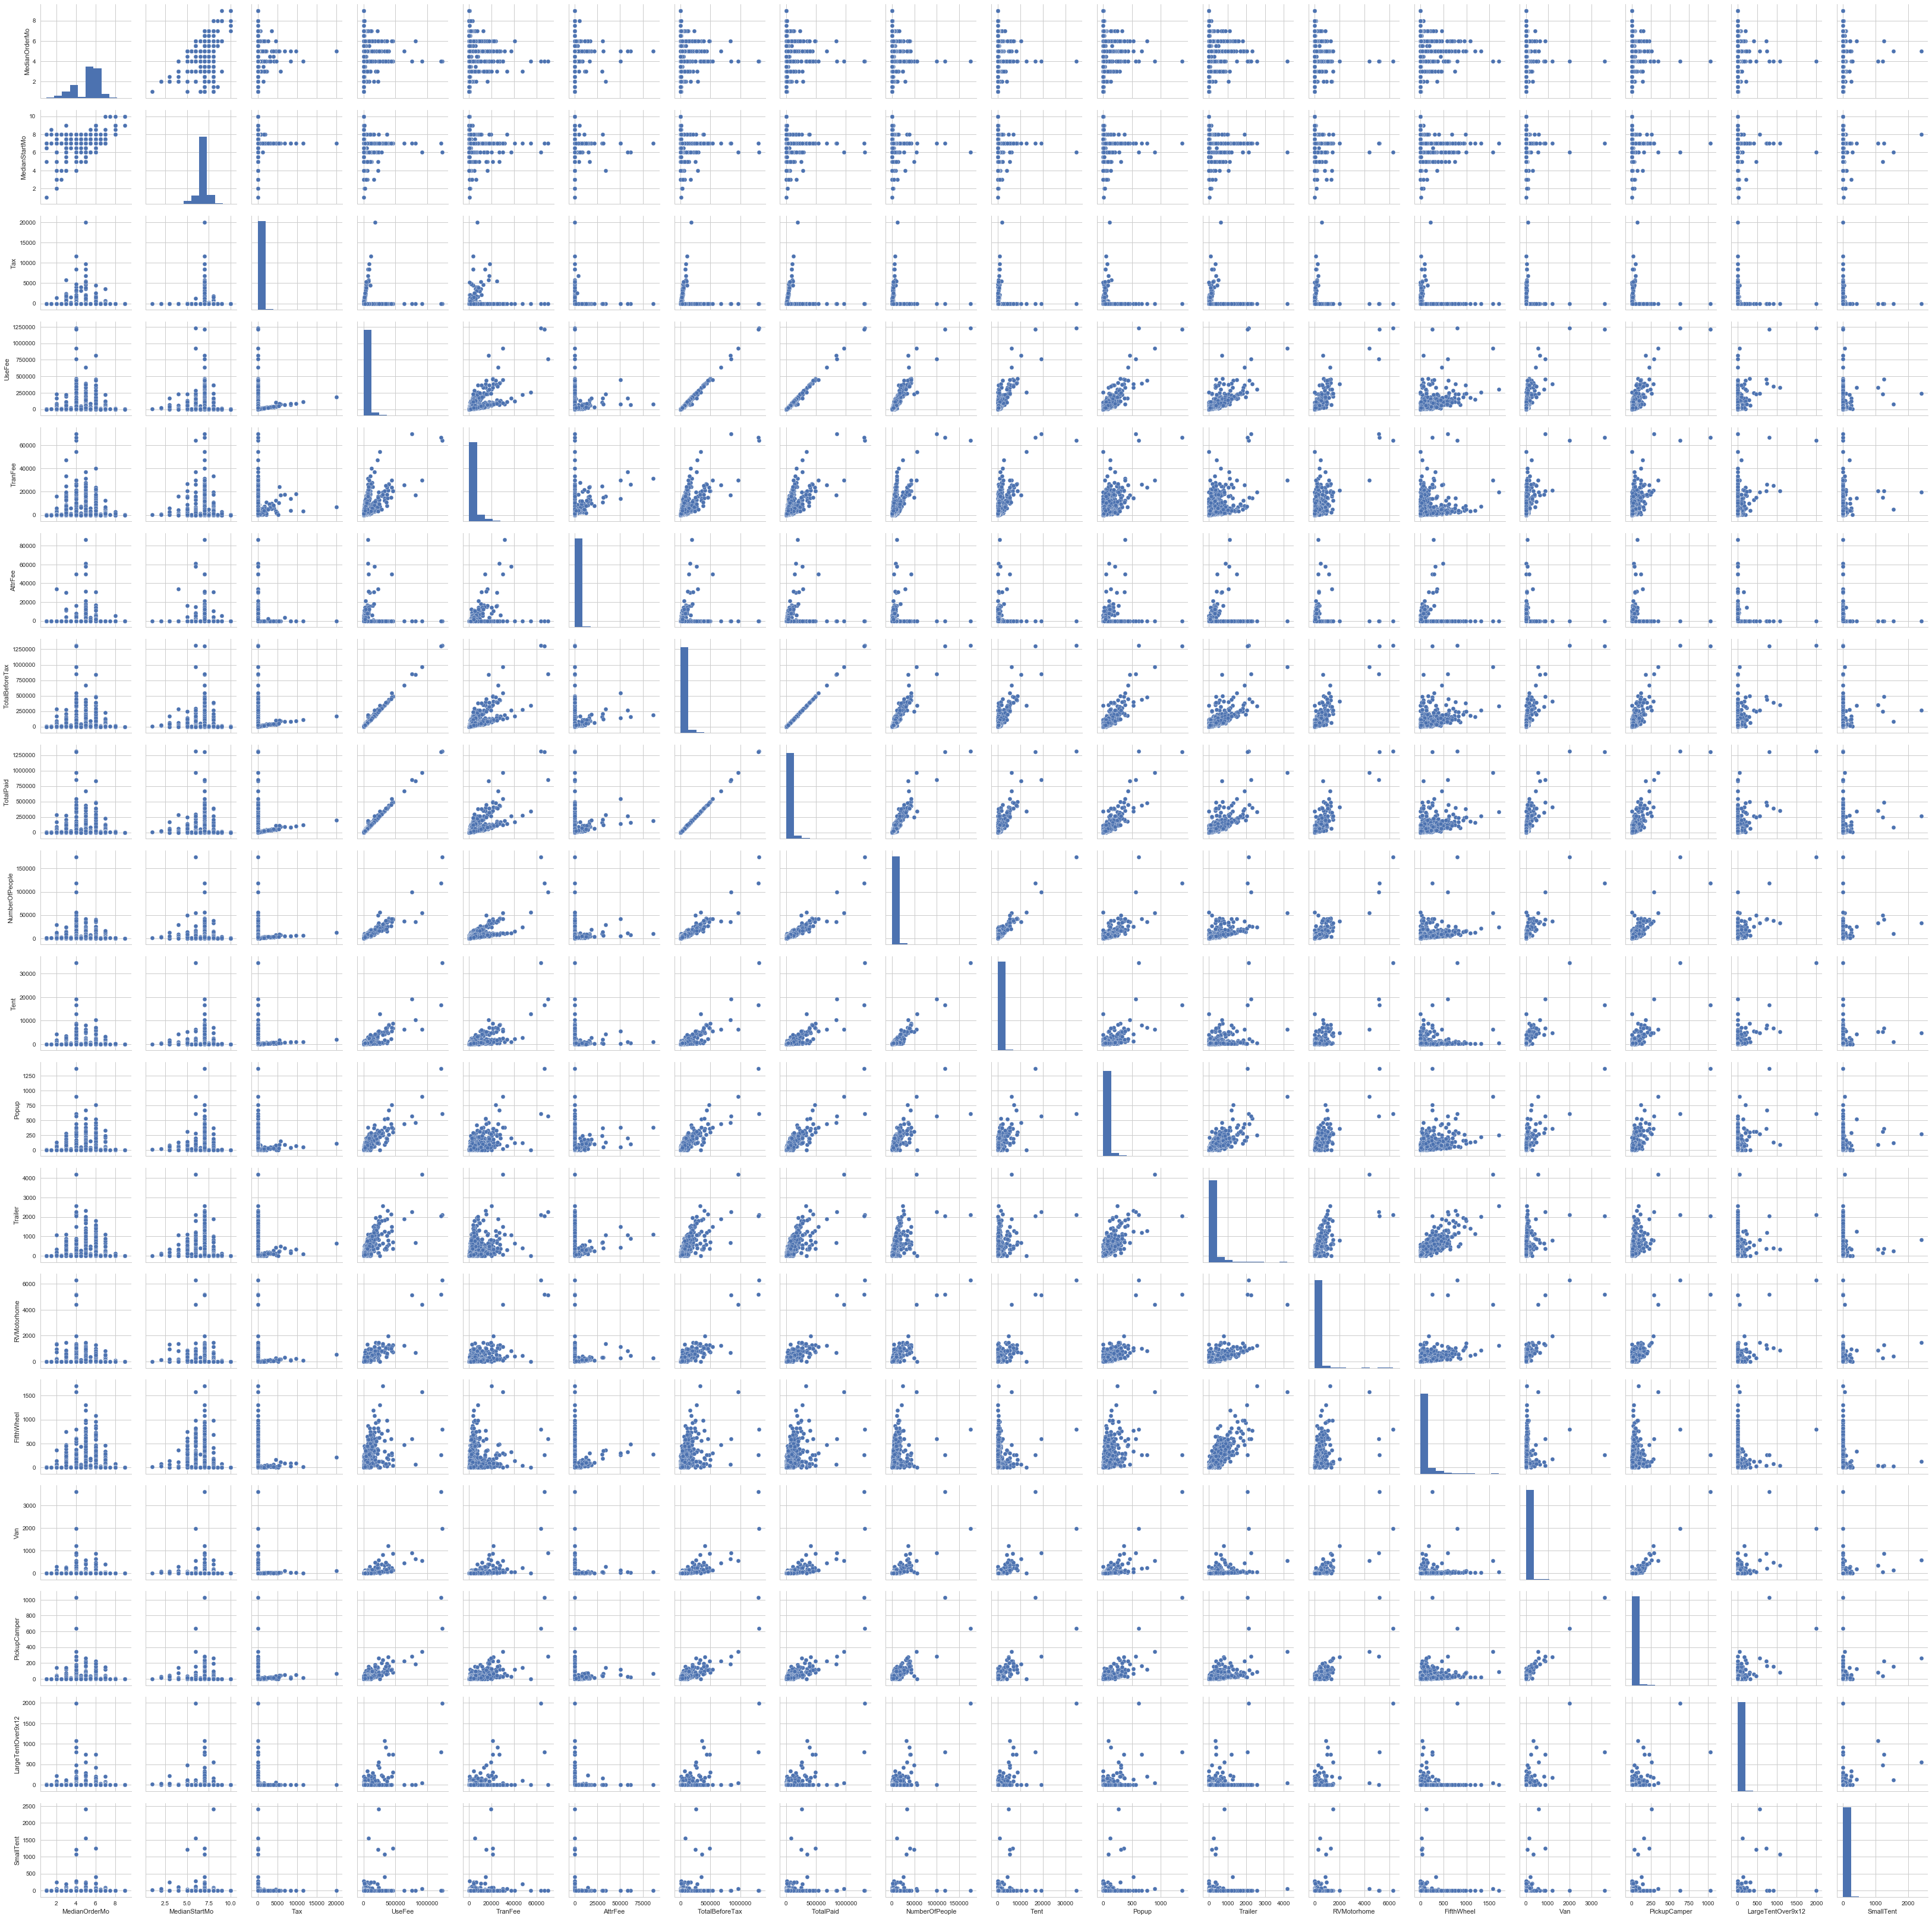

In [178]:
sns.pairplot(numeric)

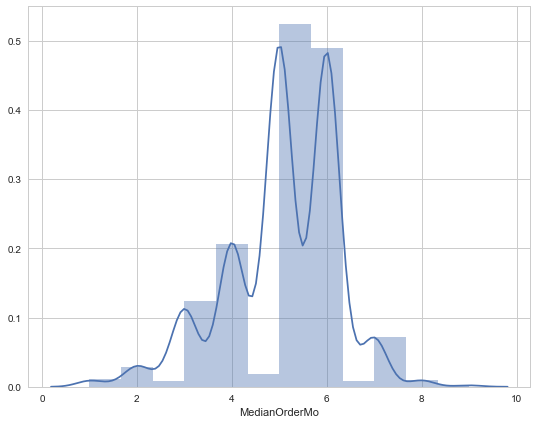

In [181]:
sns.distplot(df15CampFinal.MedianOrderMo, bins=12, hist=True)

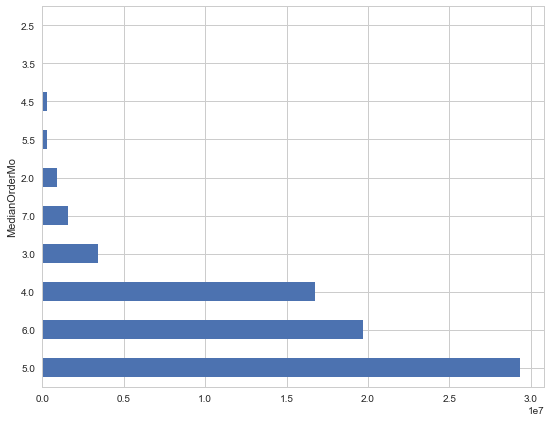

In [182]:
df15CampFinal.groupby('MedianOrderMo')['TotalPaid'].sum().sort_values(ascending=False).head(10).plot(kind='barh')

In [296]:
df15CampFinal.columns

Index(['Park', 'MedianOrderMo', 'MedianStartMo', 'Tax', 'UseFee', 'TranFee',
       'AttrFee', 'TotalBeforeTax', 'TotalPaid', 'NumberOfPeople', 'Tent',
       'Popup', 'Trailer', 'RVMotorhome', 'FifthWheel', 'Van', 'PickupCamper',
       'LargeTentOver9x12', 'SmallTent', 'FacilityState', 'Region'],
      dtype='object')

In [298]:
df15.columns

Index(['HistoricalReservationID', 'OrderNumber', 'Agency', 'OrgID',
       'CodeHierarchy', 'RegionCode', 'RegionDescription', 'ParentLocationID',
       'ParentLocation', 'LegacyFacilityID', 'Park', 'SiteType', 'UseType',
       'ProductID', 'EntityType', 'EntityID', 'FacilityID', 'FacilityZIP',
       'FacilityState', 'FacilityLongitude', 'FacilityLatitude', 'CustomerZIP',
       'CustomerState', 'CustomerCountry', 'Tax', 'UseFee', 'TranFee',
       'AttrFee', 'TotalBeforeTax', 'TotalPaid', 'StartDate', 'EndDate',
       'OrderDate', 'NumberOfPeople', 'Tent', 'Popup', 'Trailer',
       'RVMotorhome', 'Boat', 'HorseTrailer', 'Car', 'FifthWheel', 'Van',
       'CanoeKayak', 'BoatTrailer', 'Motorcycle', 'Truck', 'Bus', 'Bicycle',
       'Snowmobile', 'OffRoadlAllTerrainVehicle', 'PowerBoat', 'PickupCamper',
       'LargeTentOver9x12', 'SmallTent', 'Marinaboat'],
      dtype='object')

In [303]:
for_indexing =df15CampFinal[['MedianOrderMo','FacilityState','TotalPaid']]

In [305]:
df15.head(2)

,HistoricalReservationID,OrderNumber,Agency,OrgID,CodeHierarchy,RegionCode,RegionDescription,ParentLocationID,ParentLocation,LegacyFacilityID,...,Truck,Bus,Bicycle,Snowmobile,OffRoadlAllTerrainVehicle,PowerBoat,PickupCamper,LargeTentOver9x12,SmallTent,Marinaboat
0,2019039433,2-32196786,USFS,131,|1|70903|74312|74395|74751|74197|,F40204,CASCADE RD,74395,BOISE NF - FS,74197,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019134646,2-32195127,USACE,130,|1|70902|74307|74362|74636|73388|,CM5002570,CANTON LAKE,74362,TULSA DISTRICT,73388,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


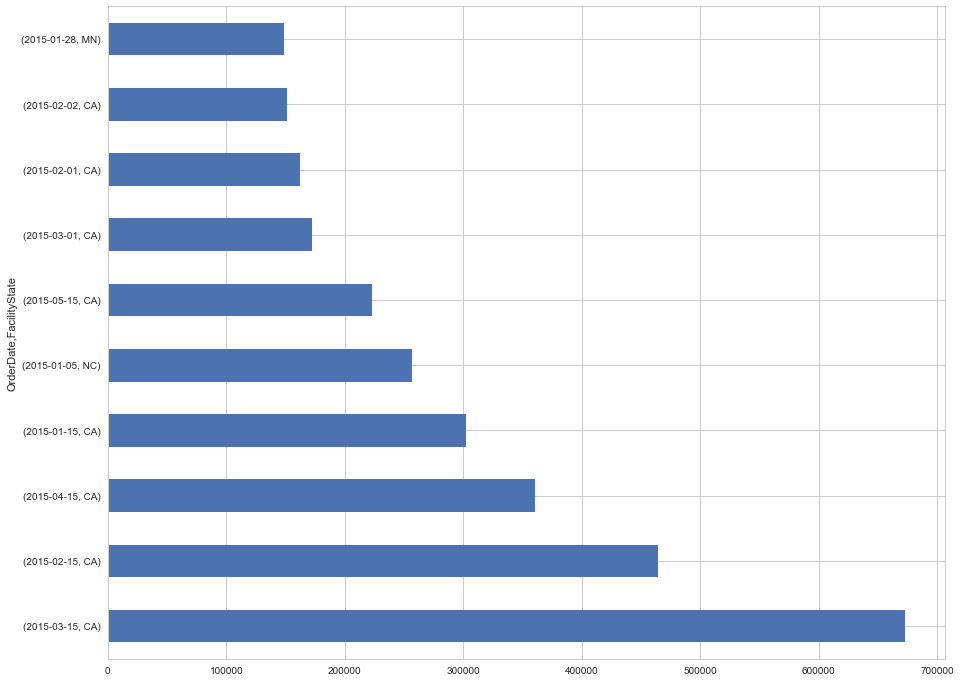

In [307]:
df15.groupby(['OrderDate','FacilityState'])['TotalPaid'].sum().sort_values(ascending=False).head(10).plot(kind='barh')

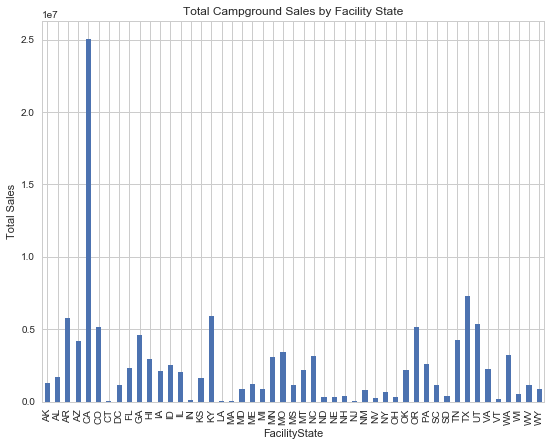

In [191]:
fig_size = plt.rcParams['figure.figsize']
var = df15[['TotalPaid','FacilityState']].groupby('FacilityState').TotalPaid.sum()
fig = plt.figure()
fig_size[0] = 15
fig_size[1] = 12
ax1 = fig.add_subplot(1,1,1,)
ax1.set_xlabel('Facility State')
ax1.set_ylabel('Total Sales')
ax1.set_title('Total Campground Sales by Facility State')
var.plot(kind = 'bar')

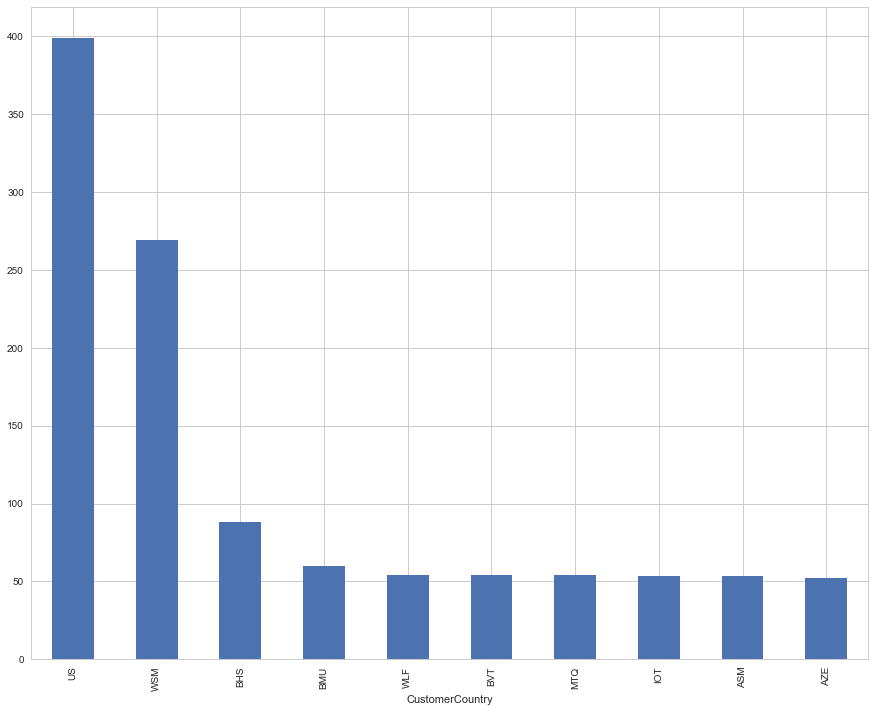

In [192]:
df15.groupby('CustomerCountry')['TotalPaid'].mean().sort_values(ascending=False).head(10).plot(kind='bar')

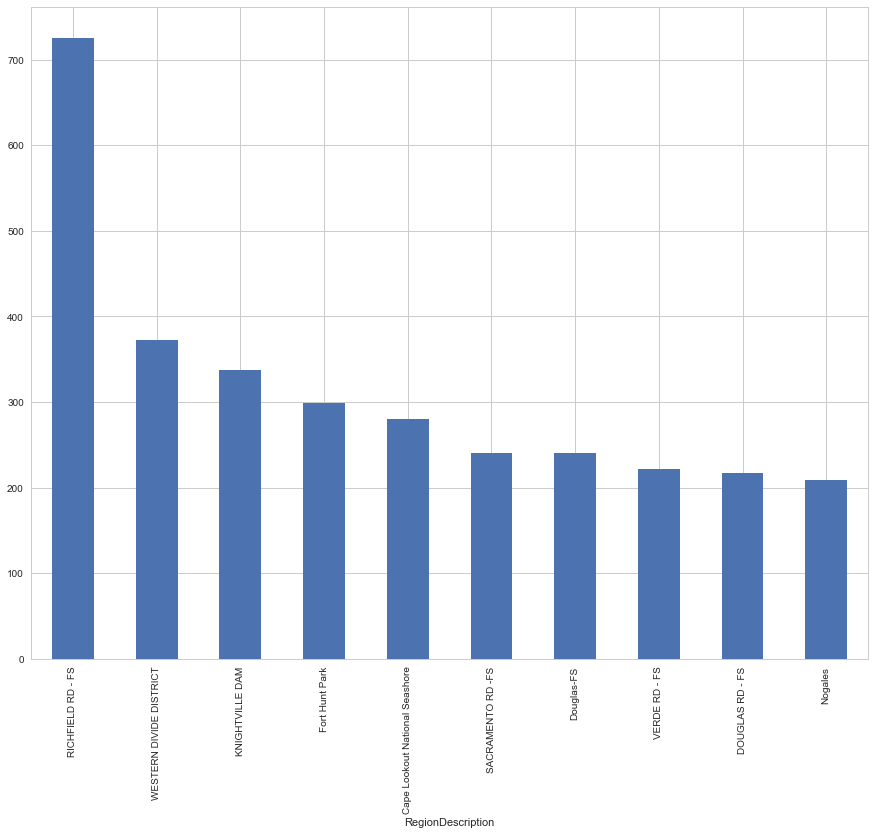

In [193]:
df15.groupby('RegionDescription')['TotalPaid'].mean().sort_values(ascending=False).head(10).plot(kind='bar')

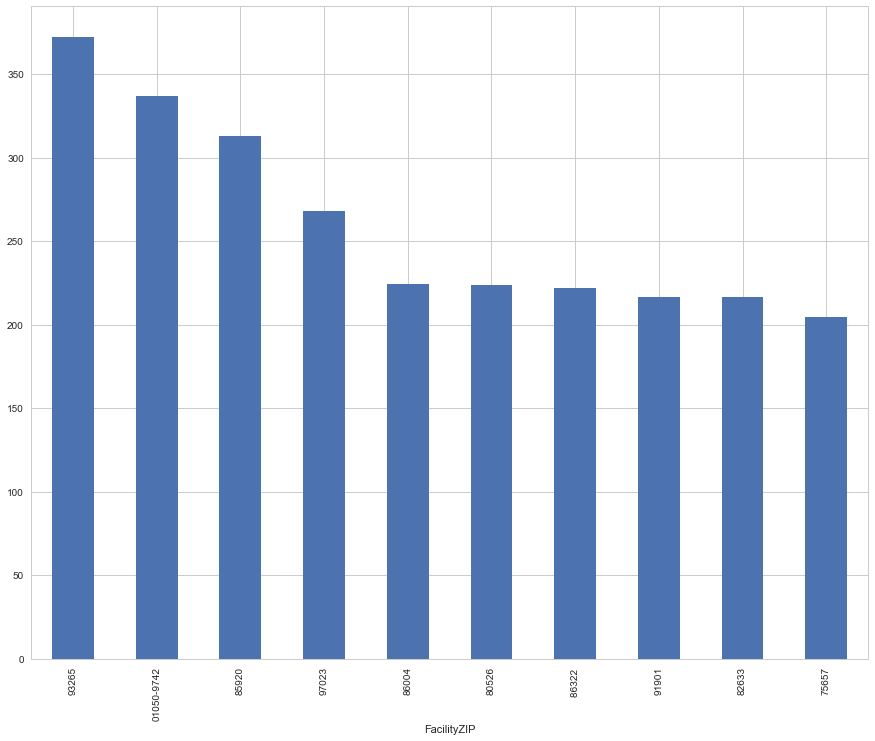

In [194]:
df15.groupby('FacilityZIP')['TotalPaid'].mean().sort_values(ascending=False).head(10).plot(kind='bar')

In [196]:
df15CampFinal['NumberOfPeople'].mode()

0    580
1    710
dtype: int64

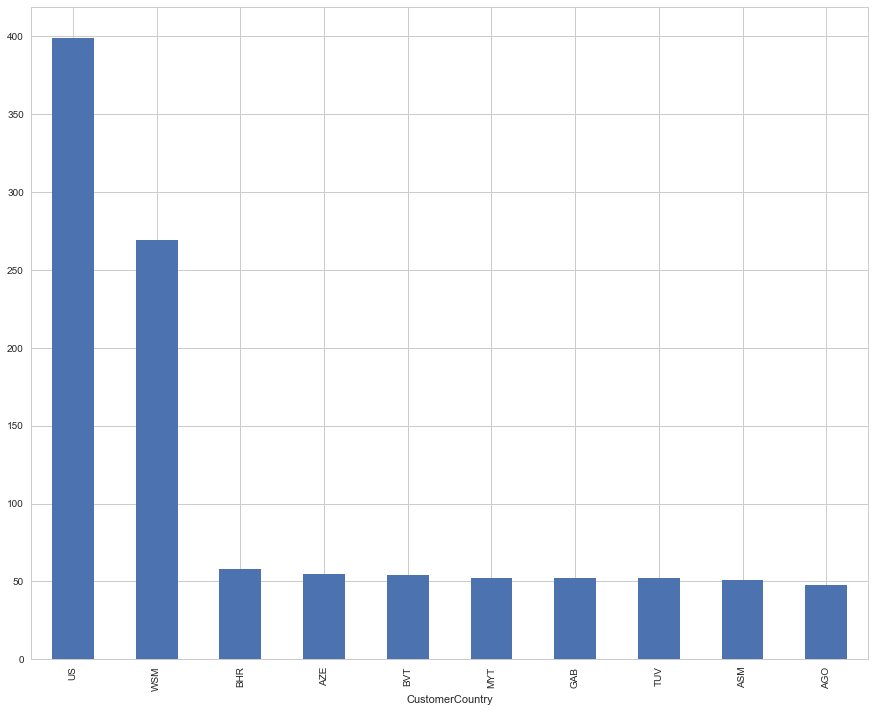

In [201]:
df15.groupby('CustomerCountry')['TotalPaid'].median().sort_values(ascending=False).head(10).plot(kind='bar')


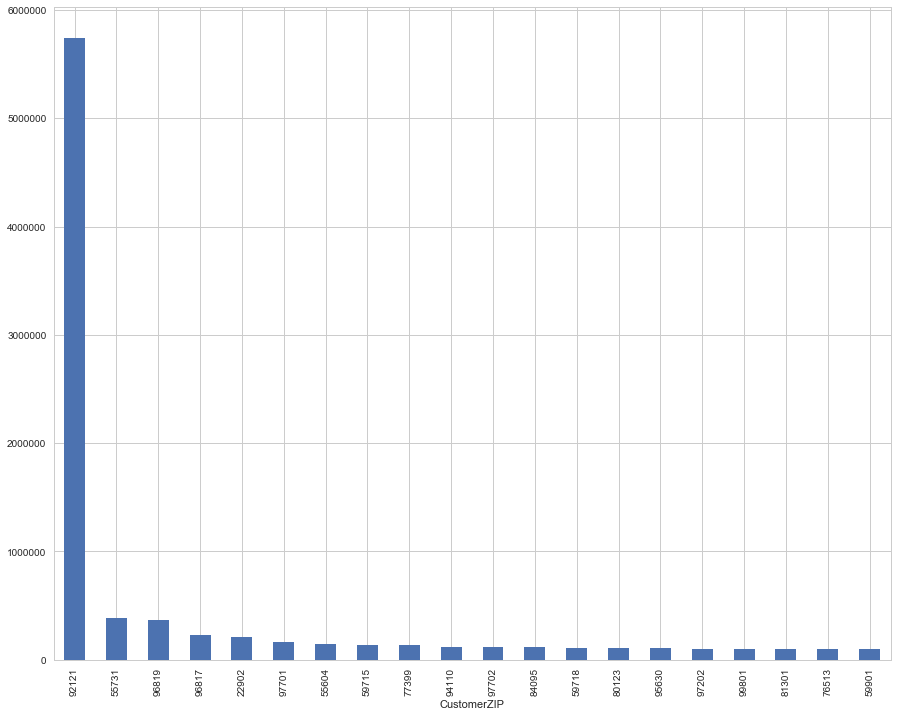

In [202]:
df15.groupby('CustomerZIP')['TotalPaid'].sum().sort_values(ascending=False).head(20).plot(kind='bar')

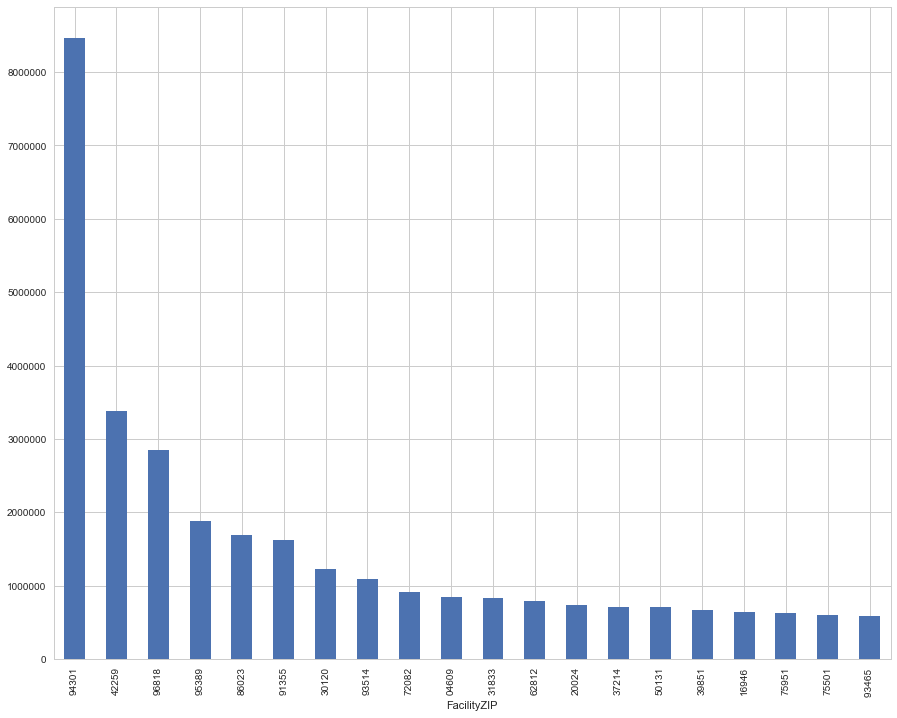

In [203]:
df15.groupby('FacilityZIP')['TotalPaid'].sum().sort_values(ascending=False).head(20).plot(kind='bar')

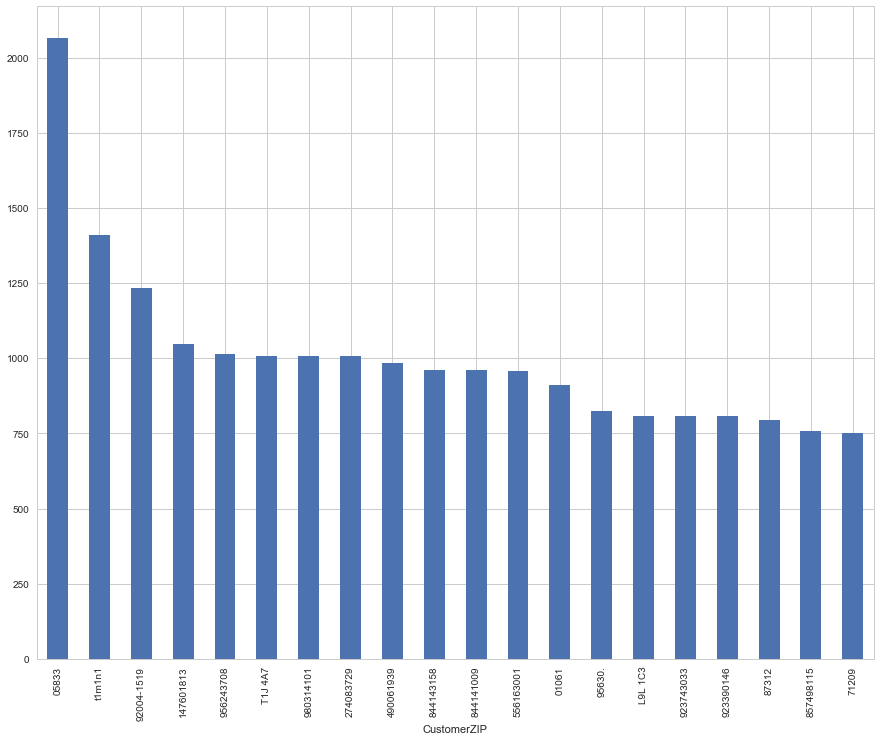

In [204]:
df15.groupby('CustomerZIP')['TotalPaid'].mean().sort_values(ascending=False).head(20).plot(kind='bar')

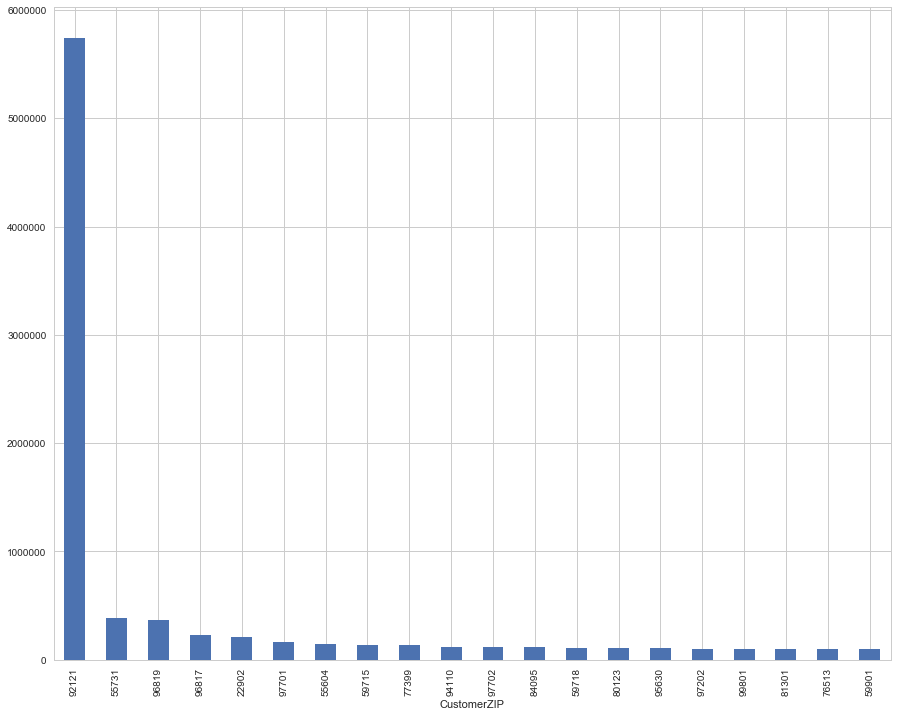

In [205]:
df15.groupby('CustomerZIP')['TotalPaid'].sum().sort_values(ascending=False).head(20).plot(kind='bar')

In [206]:
df15['CustomerCountry'].value_counts().head(10)

USA    2852155
CAN      25962
DEU      17216
GBR       8200
NLD       7702
FRA       6595
AUS       5481
CHE       4643
BEL       2213
DNK       1633
Name: CustomerCountry, dtype: int64

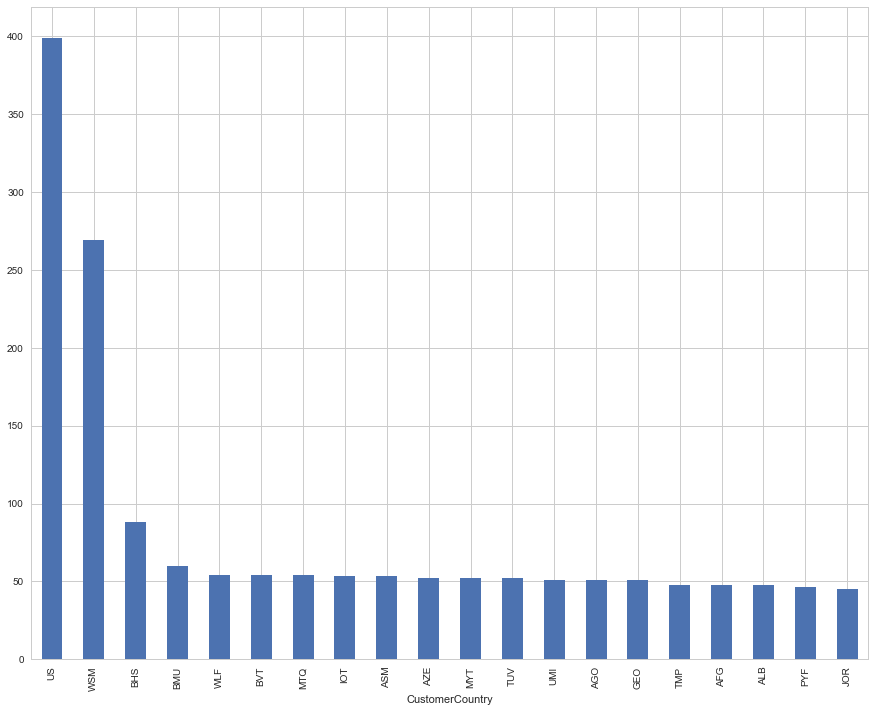

In [207]:
df15.groupby('CustomerCountry')['TotalPaid'].mean().sort_values(ascending=False).head(20).plot(kind='bar')
# Note that I took a sample of .01 so in this case, the number of customers from different countries "CustomerCountry" is very small in relation to the US.

# Model the data

Next is the modeling stage. I performed several classification models. The Confusion Matrix showed that most of the items went into the Mountain category. I would like to see what happens if I do a subset of the data and run it through different models. I plan to do another model with GradientBoost.

In [208]:
df15CampFinal.columns

Index(['Park', 'MedianOrderMo', 'MedianStartMo', 'Tax', 'UseFee', 'TranFee',
       'AttrFee', 'TotalBeforeTax', 'TotalPaid', 'NumberOfPeople', 'Tent',
       'Popup', 'Trailer', 'RVMotorhome', 'FifthWheel', 'Van', 'PickupCamper',
       'LargeTentOver9x12', 'SmallTent', 'FacilityState', 'Region'],
      dtype='object')

# Define Features and Target

The target variable is Region which had been created and mapped to State as mentioned above. The fact that region is is mapped to State is why State is excluded from the feature set.


In [209]:
X = df15CampFinal[[c for c in df15CampFinal.columns if not 'Park' in c and not 'Region' in c and not 'State' in c]]

In [210]:
y = df15CampFinal['Region']

# Train Test Split

In [211]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.33)

In [212]:
X_train.shape, y_train.shape

((1409, 18), (1409,))

In [213]:
X_test.shape, y_test.shape

((695, 18), (695,))

In [214]:
X.columns

Index(['MedianOrderMo', 'MedianStartMo', 'Tax', 'UseFee', 'TranFee', 'AttrFee',
       'TotalBeforeTax', 'TotalPaid', 'NumberOfPeople', 'Tent', 'Popup',
       'Trailer', 'RVMotorhome', 'FifthWheel', 'Van', 'PickupCamper',
       'LargeTentOver9x12', 'SmallTent'],
      dtype='object')

In [216]:
df15CampFinal.columns

Index(['Park', 'MedianOrderMo', 'MedianStartMo', 'Tax', 'UseFee', 'TranFee',
       'AttrFee', 'TotalBeforeTax', 'TotalPaid', 'NumberOfPeople', 'Tent',
       'Popup', 'Trailer', 'RVMotorhome', 'FifthWheel', 'Van', 'PickupCamper',
       'LargeTentOver9x12', 'SmallTent', 'FacilityState', 'Region'],
      dtype='object')

# Logistic Regression Model

The first model to be run is a logigistic regression model which is a good model to start looking at categorical data with.

In [217]:
lr = LogisticRegression()

In [318]:
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [319]:
lr.score(X_train, y_train)

0.51951738821859472

In [315]:
lr.score(X_test, y_test)

0.5136690647482014

In [320]:
lr_predictions = lr.predict(X_test)

In [222]:
X.columns

Index(['MedianOrderMo', 'MedianStartMo', 'Tax', 'UseFee', 'TranFee', 'AttrFee',
       'TotalBeforeTax', 'TotalPaid', 'NumberOfPeople', 'Tent', 'Popup',
       'Trailer', 'RVMotorhome', 'FifthWheel', 'Van', 'PickupCamper',
       'LargeTentOver9x12', 'SmallTent'],
      dtype='object')

In [223]:
lr.coef_

array([[ -6.01165822e-02,  -2.58699568e-01,  -4.33163102e-02,
         -1.39712796e-04,  -2.28627941e-04,  -8.94620586e-05,
          6.60348366e-03,  -6.47250580e-03,  -2.07467346e-04,
          1.19790967e-03,   1.44767268e-02,   2.24340010e-03,
         -1.15723266e-03,   3.37571660e-04,   4.22070750e-03,
         -1.52072910e-02,  -5.78662577e-03,  -2.91715313e-03],
       [ -1.16123120e-01,  -2.00931033e-01,  -2.30400053e-02,
          2.75848095e-03,   2.33213473e-03,   2.77568031e-03,
          1.81358595e-02,  -2.08640519e-02,  -3.01732499e-04,
          1.39100195e-03,   5.53736967e-02,  -1.06204694e-02,
         -1.49983838e-02,   2.64606514e-02,  -5.96223048e-02,
          7.40158361e-03,  -1.46917774e-02,   1.94390854e-03],
       [ -1.13066711e-01,  -1.56358428e-01,  -2.03884802e-02,
         -3.79836910e-03,  -4.09134359e-03,  -3.68915129e-03,
          1.25668053e-02,  -8.65009332e-03,  -2.52051788e-03,
         -2.37250782e-03,   1.12913000e-02,   1.33901570e-02,
      

In [224]:
index=X.columns
index

Index(['MedianOrderMo', 'MedianStartMo', 'Tax', 'UseFee', 'TranFee', 'AttrFee',
       'TotalBeforeTax', 'TotalPaid', 'NumberOfPeople', 'Tent', 'Popup',
       'Trailer', 'RVMotorhome', 'FifthWheel', 'Van', 'PickupCamper',
       'LargeTentOver9x12', 'SmallTent'],
      dtype='object')

In [283]:
lr.coef_.shape

(18, 10)

In [235]:
cols = ['MedianOrderMo', 'MedianStartMo', 'Tax', 'UseFee', 'TranFee', 'AttrFee','TotalBeforeTax', 'TotalPaid', 'NumberOfPeople', 'Tent', 'Popup','Trailer', 'RVMotorhome', 'FifthWheel', 'Van', 'PickupCamper','LargeTentOver9x12', 'SmallTent']

In [236]:
coeff_df = pd.DataFrame(lr.coef_, cols )

In [321]:
gridpreds = grid.predict(X_test)

def conmatrix(predictions, y, model):
    conmat_1 = confusion_matrix(y, predictions, labels=model.classes_)
    conmat_1 = pd.DataFrame(conmat_1, columns=model.classes_, index=model.classes_)
    return conmat_1
    

conmatrix(predictions=lr_predictions,y=y_test,model=lr)

,Appalachian,Heartland,Mid Atlantic,Midwest,Mountain,New England,Noncontiguous,Pacific Coast,Southeast,Southwest
Appalachian,4,2,1,0,10,1,0,12,8,7
Heartland,2,27,0,0,9,0,0,11,1,18
Mid Atlantic,0,0,0,0,3,0,0,6,4,1
Midwest,0,1,0,1,11,1,0,11,0,3
Mountain,2,3,0,0,97,0,1,73,0,16
New England,0,1,0,0,1,2,0,2,0,0
Noncontiguous,0,0,0,0,1,0,2,0,0,0
Pacific Coast,1,0,0,0,12,0,0,178,1,9
Southeast,4,4,0,2,5,0,0,10,13,32
Southwest,0,1,0,1,17,0,0,16,0,33


In [322]:
print(classification_report(y_test,lr_predictions))

               precision    recall  f1-score   support

  Appalachian       0.31      0.09      0.14        45
    Heartland       0.69      0.40      0.50        68
 Mid Atlantic       0.00      0.00      0.00        14
      Midwest       0.25      0.04      0.06        28
     Mountain       0.58      0.51      0.54       192
  New England       0.50      0.33      0.40         6
Noncontiguous       0.67      0.67      0.67         3
Pacific Coast       0.56      0.89      0.68       201
    Southeast       0.48      0.19      0.27        70
    Southwest       0.28      0.49      0.35        68

  avg / total       0.50      0.51      0.48       695



# GridSearchCV

Next, run the logistic regression with a GridSearchCV. This will allow for multiple parameters to achieve the best score.

In [240]:
params = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

In [324]:
grid_lr = GridSearchCV(LogisticRegression(), param_grid=params, cv=5, n_jobs=-1)

In [325]:
grid_lr.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [326]:
grid_lr.score(X_train, y_train)

0.51951738821859472

In [327]:
grid_lr.score(X_test, y_test)

0.5136690647482014

In [328]:
grid_lr.best_score_

0.52022711142654365

In [329]:
grid_lr_predictions = grid_lr.predict(X_test)

In [248]:
scores = cross_val_score(lr, X, y, cv=5)
print('Cross-validated scores =', scores)

Cross-validated scores = [ 0.5         0.50356295  0.54761905  0.51551313  0.52392344]


In [330]:
grid_lr_preds = grid_lr.predict(X_test)

def conmatrix(predictions, y, model):
    conmat_1 = confusion_matrix(y, predictions, labels=model.classes_)
    conmat_1 = pd.DataFrame(conmat_1, columns=model.classes_, index=model.classes_)
    return conmat_1
    

conmatrix(predictions=grid_lr_preds,y=y_test,model=lr)

,Appalachian,Heartland,Mid Atlantic,Midwest,Mountain,New England,Noncontiguous,Pacific Coast,Southeast,Southwest
Appalachian,4,2,1,0,10,1,0,12,8,7
Heartland,2,27,0,0,9,0,0,11,1,18
Mid Atlantic,0,0,0,0,3,0,0,6,4,1
Midwest,0,1,0,1,11,1,0,11,0,3
Mountain,2,3,0,0,97,0,1,73,0,16
New England,0,1,0,0,1,2,0,2,0,0
Noncontiguous,0,0,0,0,1,0,2,0,0,0
Pacific Coast,1,0,0,0,12,0,0,178,1,9
Southeast,4,4,0,2,5,0,0,10,13,32
Southwest,0,1,0,1,17,0,0,16,0,33


In [331]:
print(classification_report(y_test,grid_lr_preds))

               precision    recall  f1-score   support

  Appalachian       0.31      0.09      0.14        45
    Heartland       0.69      0.40      0.50        68
 Mid Atlantic       0.00      0.00      0.00        14
      Midwest       0.25      0.04      0.06        28
     Mountain       0.58      0.51      0.54       192
  New England       0.50      0.33      0.40         6
Noncontiguous       0.67      0.67      0.67         3
Pacific Coast       0.56      0.89      0.68       201
    Southeast       0.48      0.19      0.27        70
    Southwest       0.28      0.49      0.35        68

  avg / total       0.50      0.51      0.48       695



# Random Forest Classifier

Next model is a Random Forest Classifier. Below is a Confusion Matrix and a Classification Report to give an idea how the model did in predicting the regions.

In [250]:
rf = RandomForestClassifier()

In [332]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [333]:
rf.score(X_test, y_test)

0.49640287769784175

In [334]:
rf_predictions = rf.predict(X_test)

In [335]:
def conmatrix(predictions, y, model):
    conmat_1 = confusion_matrix(y, predictions, labels=model.classes_)
    conmat_1 = pd.DataFrame(conmat_1, columns=model.classes_, index=model.classes_)
    return conmat_1
    

conmatrix(predictions=rf_predictions,y=y_test,model=rf)

,Appalachian,Heartland,Mid Atlantic,Midwest,Mountain,New England,Noncontiguous,Pacific Coast,Southeast,Southwest
Appalachian,11,6,0,1,10,0,0,9,7,1
Heartland,10,27,0,5,10,0,0,8,2,6
Mid Atlantic,3,0,0,2,3,0,0,3,3,0
Midwest,5,2,0,2,13,0,0,5,1,0
Mountain,10,6,1,2,133,0,0,38,2,0
New England,2,0,0,0,0,0,0,3,1,0
Noncontiguous,1,0,0,0,2,0,0,0,0,0
Pacific Coast,13,1,0,4,47,0,0,131,1,4
Southeast,6,13,0,2,10,0,0,5,20,14
Southwest,6,5,0,1,10,0,0,15,10,21


In [336]:
print(classification_report(y_test,rf_predictions))

               precision    recall  f1-score   support

  Appalachian       0.16      0.24      0.20        45
    Heartland       0.45      0.40      0.42        68
 Mid Atlantic       0.00      0.00      0.00        14
      Midwest       0.11      0.07      0.09        28
     Mountain       0.56      0.69      0.62       192
  New England       0.00      0.00      0.00         6
Noncontiguous       0.00      0.00      0.00         3
Pacific Coast       0.60      0.65      0.63       201
    Southeast       0.43      0.29      0.34        70
    Southwest       0.46      0.31      0.37        68

  avg / total       0.48      0.50      0.48       695



/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [261]:
feature_imp = pd.DataFrame(rf.feature_importances_, index=X.columns)

In [262]:
feature_imp.sort_values(by=[0], ascending=False)

,0
TranFee,0.098199
Tent,0.088704
FifthWheel,0.083553
Popup,0.076813
Trailer,0.073025
NumberOfPeople,0.072914
UseFee,0.070808
TotalBeforeTax,0.070000
TotalPaid,0.063924
RVMotorhome,0.060882


# Decision Tree Classifier

Below is a Decision Tree Classifier. Also , there isa graph of the decision tree and another Confusion matrix related to this model.

In [263]:
dt = DecisionTreeClassifier()

In [264]:
dt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [265]:
dt.score(X_test, y_test)

0.42589928057553955

In [266]:
dt.predict(X_test)

array(['Pacific Coast', 'Mid Atlantic', 'Appalachian', 'Pacific Coast',
       'Southeast', 'Noncontiguous', 'Appalachian', 'Heartland',
       'Appalachian', 'Mountain', 'Mountain', 'Pacific Coast', 'Mountain',
       'Midwest', 'Southeast', 'Pacific Coast', 'Pacific Coast',
       'Mountain', 'Pacific Coast', 'Pacific Coast', 'Pacific Coast',
       'Pacific Coast', 'Mountain', 'Pacific Coast', 'Southwest',
       'Southwest', 'Southeast', 'Appalachian', 'Pacific Coast',
       'Mountain', 'Pacific Coast', 'Mountain', 'Mountain', 'Southwest',
       'Heartland', 'Mountain', 'Appalachian', 'Pacific Coast',
       'Southwest', 'Southwest', 'Southwest', 'Pacific Coast',
       'Pacific Coast', 'Southwest', 'Southwest', 'Southwest',
       'Pacific Coast', 'Mountain', 'Mountain', 'Midwest', 'Mountain',
       'Southeast', 'Southeast', 'Appalachian', 'Mountain', 'Heartland',
       'Appalachian', 'Pacific Coast', 'Pacific Coast', 'Pacific Coast',
       'Mountain', 'Midwest', 'Pacific Coa

In [267]:
dt_feat_imp = dt.feature_importances_ 

In [268]:
dt_feat_imp_df = pd.DataFrame(X.columns, dt_feat_imp )

In [269]:
dt_feat_imp_df

,0
0.032424,MedianOrderMo
0.054628,MedianStartMo
0.028151,Tax
0.071717,UseFee
0.101958,TranFee
0.016682,AttrFee
0.043695,TotalBeforeTax
0.062401,TotalPaid
0.103378,NumberOfPeople
0.090534,Tent


In [270]:
dt_feat_imp_df.rename(columns={'index':'Feature Importance'}, inplace=True)

In [271]:
dt_feat_imp_df.columns = ['Features'] # Rename column 'Features

In [272]:
dt_feat_imp_df = dt_feat_imp_df.reset_index().sort_values(by='index', ascending=False)

In [273]:
dt_feat_imp_df

,index,Features
13,0.114458,FifthWheel
8,0.103378,NumberOfPeople
4,0.101958,TranFee
9,0.090534,Tent
10,0.078784,Popup
3,0.071717,UseFee
11,0.070621,Trailer
7,0.062401,TotalPaid
12,0.055769,RVMotorhome
1,0.054628,MedianStartMo


# Graph the Decision Tree

In [274]:
# We will make some data for these functions of 100 points of x from 0.1 to 10:
# 
# 1. The general log function for x
# 2. The sin function
# 3. The exponential function
# 4. The x**2 function
#
def make_data(points=100):
    x = np.linspace(0.1, 10, points)
    
    data = {
        'x':x,
        'ygenlog':stats.genlogistic.pdf(x, 20)*500 + np.random.normal(0, 2, size=points),
        'ysin':np.sin(x)*20 + np.random.normal(0, 2, size=points),
        'yexp':np.exp(x/1.3) + np.random.normal(0, 2, size=points),
        'ysq':(x-5)**2 + np.random.normal(0, 1, size=points)
    }

    return data

# The data is put into a dictionary for convenience:
d = make_data()
x = d['x']

In [275]:
# Make a single regression tree model with depth 3 for x**2 function:
# 
x = d['x'].reshape(-1,1)
y = d['ysq']

dtree = DecisionTreeRegressor(max_depth=5)
dtree.fit(x, y)


DecisionTreeRegressor(criterion='mse', max_depth=5, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

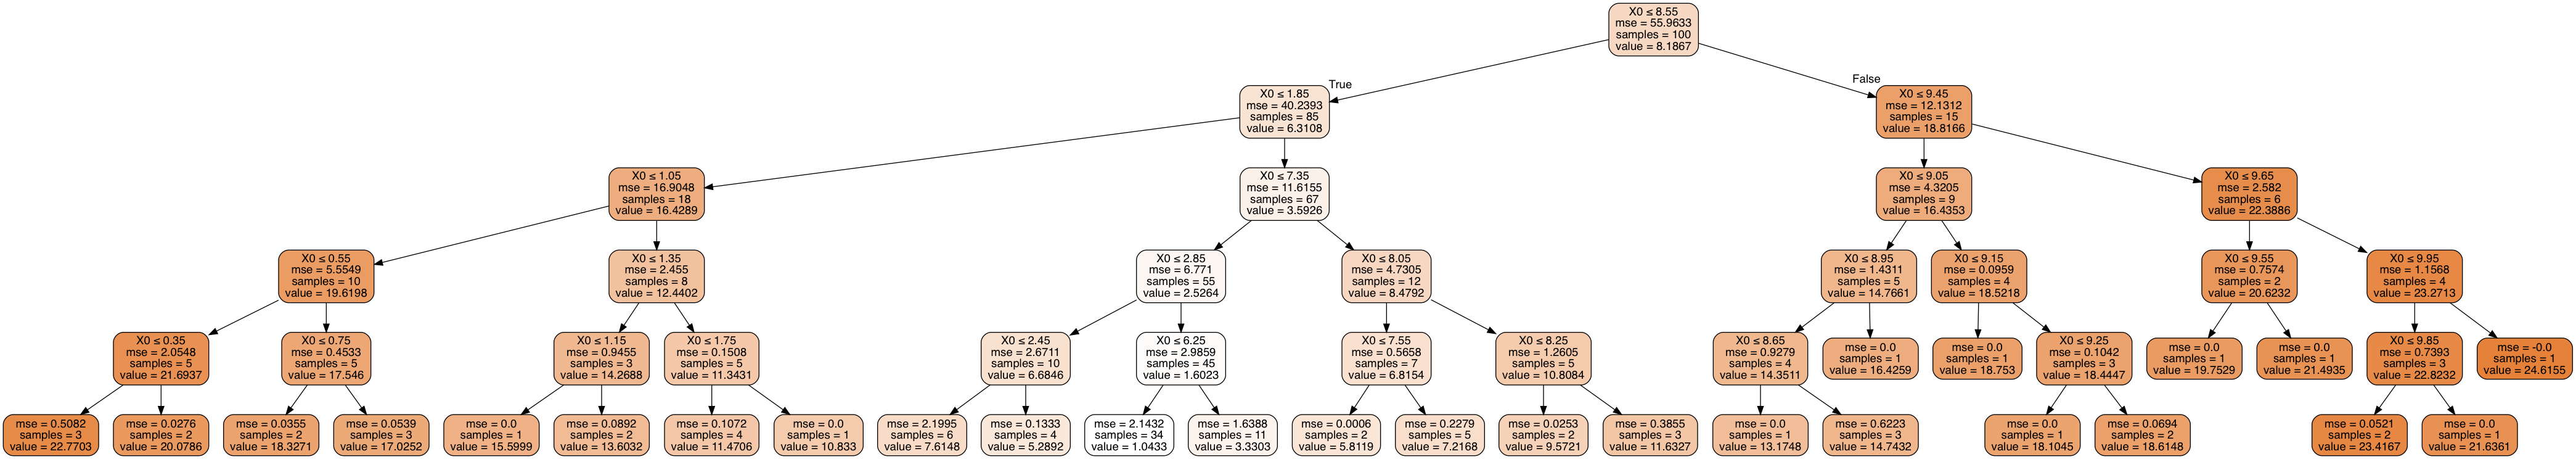

In [276]:
# REQUIREMENTS:
# pip install pydot2
# brew install graphviz

# Use graphviz to make a chart of the regression tree decision points:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

dot_data = StringIO()  

export_graphviz(dtree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)  

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())  

# Confusion Matrix

In [338]:
# predict test class:
dt_pred = dt.predict(X_test)

# predicted test probability:
y_pp = dt.predict_proba(X_test)

In [339]:
def conmatrix(ypreds, ytrue, model):
    conmat_1 = confusion_matrix(ytrue, ypreds, labels=model.classes_)
    conmat_1 = pd.DataFrame(conmat_1, columns=model.classes_, index=model.classes_)
    return conmat_1
    

conmatrix(ypreds=dt_pred,ytrue=y_test,model=dt)

,Appalachian,Heartland,Mid Atlantic,Midwest,Mountain,New England,Noncontiguous,Pacific Coast,Southeast,Southwest
Appalachian,12,6,2,0,7,0,0,10,7,1
Heartland,7,24,1,8,10,0,0,6,6,6
Mid Atlantic,4,0,1,1,3,0,0,2,2,1
Midwest,2,2,2,6,7,1,0,7,1,0
Mountain,7,3,3,16,96,1,3,42,7,14
New England,0,0,0,0,2,1,0,2,1,0
Noncontiguous,0,1,0,0,0,0,0,2,0,0
Pacific Coast,15,3,0,8,47,3,2,105,5,13
Southeast,7,5,1,5,4,0,0,2,23,23
Southwest,1,4,2,1,10,0,0,12,10,28


# DB Scan Clustering

The last model is a DB Scan Clustering model. As it turned out, no clustering took place unless eps and minimum samples were set to 1.

In [288]:
print(X.columns)

Index(['MedianOrderMo', 'MedianStartMo', 'Tax', 'UseFee', 'TranFee', 'AttrFee',
       'TotalBeforeTax', 'TotalPaid', 'NumberOfPeople', 'Tent', 'Popup',
       'Trailer', 'RVMotorhome', 'FifthWheel', 'Van', 'PickupCamper',
       'LargeTentOver9x12', 'SmallTent'],
      dtype='object')


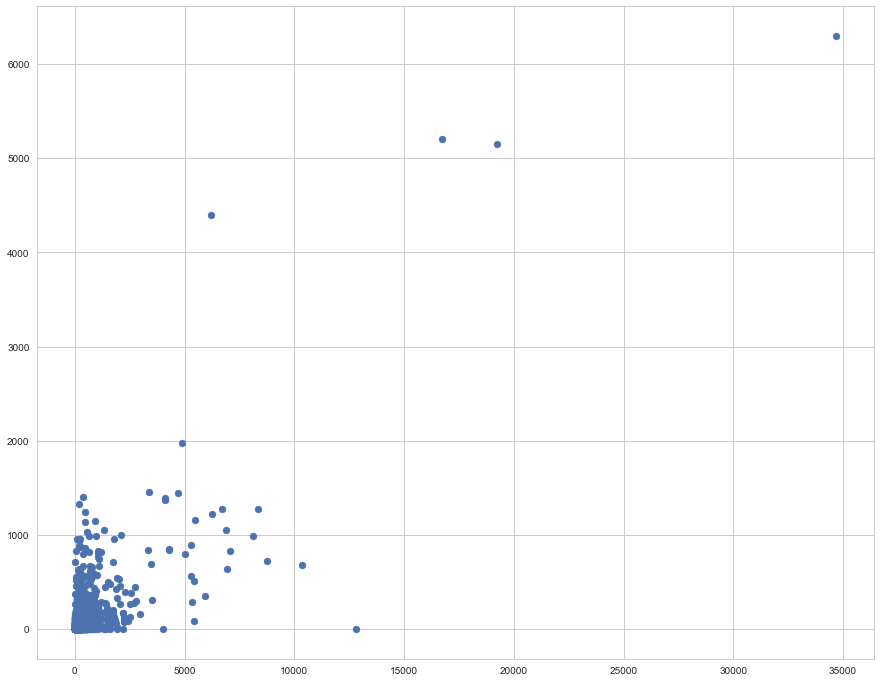

In [289]:
plt.scatter(X['Tent'], X['RVMotorhome'])

In [290]:
dbscn = DBSCAN(eps = 3, min_samples = 3)
dbscn.fit(X)

DBSCAN(algorithm='auto', eps=3, leaf_size=30, metric='euclidean',
    min_samples=3, n_jobs=1, p=None)

In [291]:
labels = dbscn.labels_  
print(labels)

[-1 -1 -1 ..., -1 -1 -1]


In [292]:
# how many clusters do we have?
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print(n_clusters_)

0


# Gradient Boost - To Do.